In [4]:
# Convolutional Neural Networks
# Setup & Die "Tensoren"
# Zuerst müssen wir verstehen, dass PyTorch Bilder nicht als NumPy-Arrays, sondern als Tensoren sieht.
# Ein Tensor ist eine höherdimensionale Matrixverallgemeinerung, die auf der Grafikkarte (GPU) leben kann.

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Gerät auswählen (GPU wenn verfügbar, sonst CPU)
# Auf Mac M1/M2 Chips wäre das "mps", auf Nvidia "cuda"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Wir trainieren auf: {device}")

# 2. Hyperparameter setzen (Die Stellschrauben)
BATCH_SIZE = 64     # Wie viele Bilder schauen wir uns gleichzeitig an?
LEARNING_RATE = 0.001 # Wie große Schritte machen wir beim Lernen?
EPOCHS = 5          # Wie oft gehen wir durch den ganzen Datensatz?

Wir trainieren auf: cpu


Lade Daten...


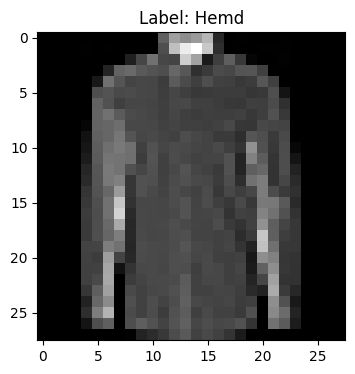

In [5]:
# Daten laden (Fashion-MNIST)
# PyTorch nimmt uns hier viel Arbeit ab. Der DataLoader mischt die Daten und serviert sie häppchenweise.
# Transformation: Bild -> Tensor -> Normalisierung (Werte zwischen -1 und 1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Daten herunterladen
print("Lade Daten...")
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Dataloader erstellen
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Klassen-Namen (damit wir wissen, was 0-9 bedeutet)
classes = ('T-Shirt', 'Hose', 'Pullover', 'Kleid', 'Mantel',
           'Sandale', 'Hemd', 'Sneaker', 'Tasche', 'Stiefel')

# Kleiner Check: Ein Bild anzeigen
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(4,4))
plt.imshow(images[0].squeeze(), cmap='gray') # .squeeze entfernt den Kanal (1, 28, 28) -> (28, 28)
plt.title(f"Label: {classes[labels[0]]}")
plt.show()

In [6]:
# Der Architekt – Das CNN bauen
# Hier übersetzen wir die Theorie-Folien direkt in Code. Wir bauen eine Klasse, die von nn.Module erbt.
# Rechnen Sie die Größen mit!
# Input: 28 x 28
# Conv1 (5 x 5 Kernel, kein Padding, Stride 1): 28 - 5 + 1 = 24 x 24
# Pool (2 x 2): 24 / 2 = 12 x 12
# Conv2 (5 x 5 Kernel): 12 - 5 + 1 = 8 x 8
# Pool (2 x 2): 8 / 2 = 4 x 4
# Flatten: 4 x 4 x 16  Filter = 256 Neuronen.

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Block 1: Conv -> ReLU -> Pool
        # Input Kanäle: 1 (Graustufen), Output Kanäle: 10 (Filter lernen 10 Merkmale)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2: Conv -> ReLU -> Pool
        # Input: 10 (von oben), Output: 20 (wir lernen mehr Details)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)

        # Fully Connected Layer (Klassifikation)
        # 4*4*20 ist die Größe der abgeflachten Feature Maps (siehe Rechnung oben)
        self.fc1 = nn.Linear(20 * 4 * 4, 50) # Hidden Layer
        self.fc2 = nn.Linear(50, 10)         # Output Layer (10 Klassen)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Der Weg der Daten durch das Netz
        x = self.pool(self.relu(self.conv1(x))) # Layer 1
        x = self.pool(self.relu(self.conv2(x))) # Layer 2

        # Flatten: Aus 3D-Würfel wird 1D-Vektor
        x = x.view(-1, 20 * 4 * 4)

        x = self.relu(self.fc1(x))
        x = self.fc2(x) # Kein Softmax hier! Das macht CrossEntropyLoss automatisch.
        return x

# Modell initialisieren und auf das Gerät schieben
net = SimpleCNN().to(device)
print(net)

SimpleCNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)


![](https://encrypted-tbn2.gstatic.com/licensed-image?q=tbn:ANd9GcQonS7jFFbs4xilesxcEq2Xdg5EDM5iuEmJhvpFI6bTw77yo0ZEzSYIiyBiE6vAi2roCFWGde54zL_ikLixq1KyebCgNAWAtAMgSU-GYbeWh5keqgA)

Start Training... (Holen Sie sich einen Kaffee, das dauert kurz)
Epoche 1/5 abgeschlossen - Loss: 0.5960
Epoche 2/5 abgeschlossen - Loss: 0.3864
Epoche 3/5 abgeschlossen - Loss: 0.3423
Epoche 4/5 abgeschlossen - Loss: 0.3141
Epoche 5/5 abgeschlossen - Loss: 0.2948
Training beendet!


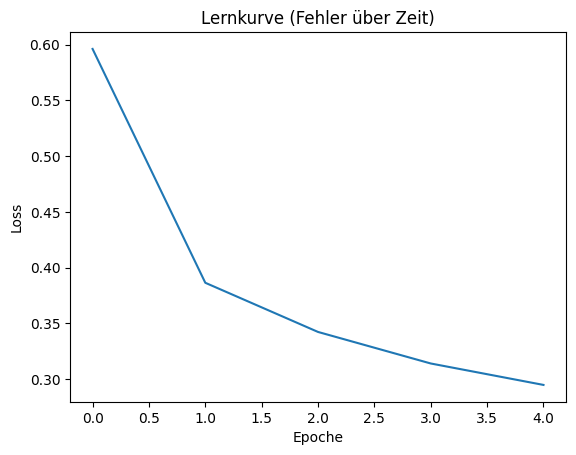

In [7]:
# Die Training Loop (Lernen lassen)

# Das ist der magische Moment. Wir sehen zu, wie der "Loss" (Fehler) sinkt.

# Verlustfunktion (Klassifikations-Fehler)
criterion = nn.CrossEntropyLoss()

# Optimierer (Der Gradienten-Abstieg / "Bergabsteiger")
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

loss_history = []

print("Start Training... (Holen Sie sich einen Kaffee, das dauert kurz)")

for epoch in range(EPOCHS):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # A. Gradienten auf Null setzen (wichtig!)
        optimizer.zero_grad()

        # B. Forward Pass (Vorhersage machen)
        outputs = net(inputs)

        # C. Loss berechnen (Wie falsch lagen wir?)
        loss = criterion(outputs, labels)

        # D. Backward Pass (Lernen / Gewichte anpassen)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Statistik pro Epoche
    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoche {epoch + 1}/{EPOCHS} abgeschlossen - Loss: {avg_loss:.4f}')

print('Training beendet!')

# Loss-Kurve plotten
plt.plot(loss_history)
plt.title("Lernkurve (Fehler über Zeit)")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.show()

In [8]:
# Evaluation (Die Prüfung)

# Wie gut ist das Modell wirklich? Wir testen es an Daten, die es noch nie gesehen hat.

correct = 0
total = 0

# torch.no_grad() spart Speicher, da wir hier nicht lernen müssen
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)

        # torch.max gibt uns den Index mit der höchsten Wahrscheinlichkeit
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Genauigkeit auf 10.000 Testbildern: {100 * correct / total:.2f}%')

Genauigkeit auf 10.000 Testbildern: 88.54%


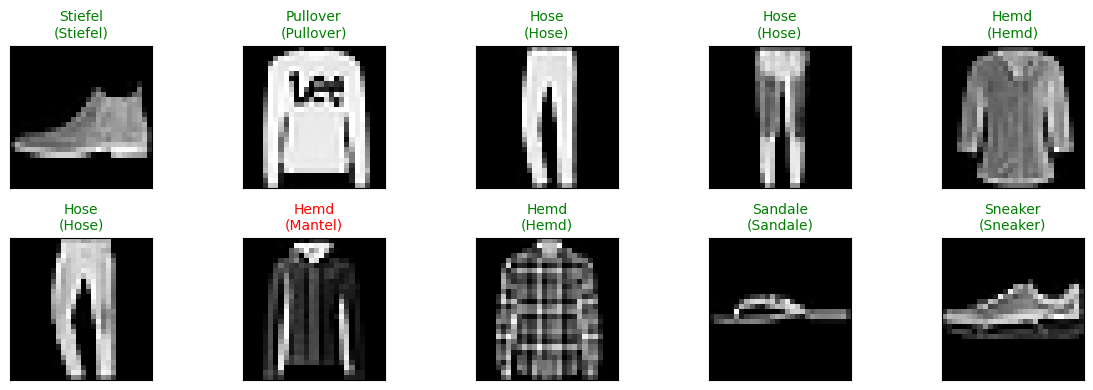

In [9]:
# Visuelle Demo (Anwendung)
# Die Zahlen sind gut, Bilder sind besser. Wir zeigen Vorhersagen an.

# Wir holen uns einen Batch Testbilder
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Vorhersage
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

# Plotten der ersten 10 Bilder
fig = plt.figure(figsize=(12, 4))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    img = images[i].numpy().squeeze()
    ax.imshow(img, cmap='gray')

    pred_label = classes[predicted[i]]
    true_label = classes[labels[i]]

    # Farbe: Grün wenn richtig, Rot wenn falsch
    color = 'green' if pred_label == true_label else 'red'

    ax.set_title(f"{pred_label}\n({true_label})", color=color, fontsize=10)

plt.tight_layout()
plt.show()

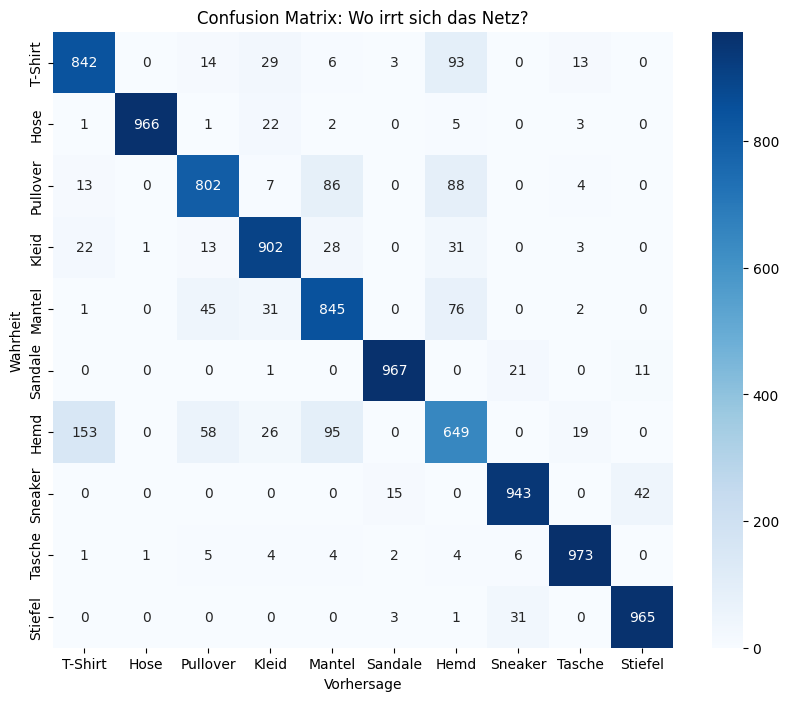

Detaillierter Bericht:
              precision    recall  f1-score   support

     T-Shirt       0.82      0.84      0.83      1000
        Hose       1.00      0.97      0.98      1000
    Pullover       0.86      0.80      0.83      1000
       Kleid       0.88      0.90      0.89      1000
      Mantel       0.79      0.84      0.82      1000
     Sandale       0.98      0.97      0.97      1000
        Hemd       0.69      0.65      0.67      1000
     Sneaker       0.94      0.94      0.94      1000
      Tasche       0.96      0.97      0.96      1000
     Stiefel       0.95      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [10]:
# Evaluation & ResNet nutzen
# Metriken berechnen (Scikit-Learn)

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

# Wir sammeln alle Vorhersagen und echte Labels vom Test-Set
y_pred = []
y_true = []

net.eval() # Wichtig: Modell in Evaluierungs-Modus (Dropout aus etc.)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# 1. Confusion Matrix visualisieren
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Wo irrt sich das Netz?")
plt.xlabel("Vorhersage")
plt.ylabel("Wahrheit")
plt.show()

# 2. Classification Report (Precision, Recall, F1)
print("Detaillierter Bericht:")
print(classification_report(y_true, y_pred, target_names=classes))

# REFLEXION:
# Schauen Sie auf "Shirt" vs "T-Shirt" oder "Pullover" vs "Coat".
# Hier verwechselt das Netz oft Dinge (niedriger Recall/Precision).
# Bei "Bag" oder "Trouser" ist es meist sehr gut.

Lade ResNet18...
Bitte lade ein Bild hoch:


Saving german-shepherd.jpg to german-shepherd (1).jpg
Bild 'german-shepherd (1).jpg' erfolgreich geladen!


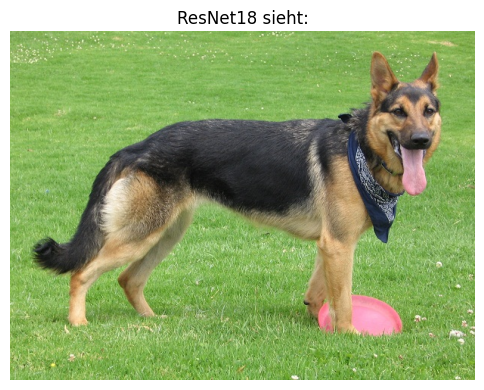

German shepherd: 99.98%
Airedale: 0.01%
bloodhound: 0.01%


In [20]:
# Transfer Learning "Out of the Box"

# Wir zeigen, wie mächtig ein ResNet18 ist, ohne dass wir es trainieren müssen. Wir klassifizieren ein Bild aus dem Internet.

import torchvision.models as models
from PIL import Image
import requests
from io import BytesIO
from google.colab import files


# 1. Wir laden ein vorgefertigtes ResNet18 (trainiert auf ImageNet)
# 'pretrained=True' (alt) oder 'weights=ResNet18_Weights.DEFAULT' (neu)
print("Lade ResNet18...")
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet.eval() # Evaluation Mode

# 2. ImageNet Klassen-Namen laden (damit wir Text statt Zahlen sehen)
url_classes = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = requests.get(url_classes).text.splitlines()


# 3. Ein echtes Bild lokal hochladen
print("Bitte lade ein Bild hoch:")
uploaded = files.upload() # Dies öffnet einen Upload-Button im Output

# Den Dateinamen der hochgeladenen Datei holen
file_name = next(iter(uploaded))

# Das Bild öffnen
img_pil = Image.open(BytesIO(uploaded[file_name])).convert('RGB')
print(f"Bild '{file_name}' erfolgreich geladen!")

# 4. Preprocessing (Genau so, wie ResNet es erwartet!)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224), # ResNet braucht 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(img_pil)
input_batch = input_tensor.unsqueeze(0) # Mini-batch dimension hinzufügen (1, 3, 224, 224)

# 5. Vorhersage
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    resnet.to('cuda')

with torch.no_grad():
    output = resnet(input_batch)

# Top 3 Wahrscheinlichkeiten
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top3_prob, top3_catid = torch.topk(probabilities, 3)

# Anzeigen
plt.figure(figsize=(6,6))
plt.imshow(img_pil)
plt.axis('off')
plt.title("ResNet18 sieht:")
plt.show()

for i in range(top3_prob.size(0)):
    print(f"{imagenet_classes[top3_catid[i]]}: {top3_prob[i].item()*100:.2f}%")


Bitte lade ein Bild hoch:


Saving Jedi_Master.png to Jedi_Master (1).png
Bild 'Jedi_Master (1).png' erfolgreich geladen!


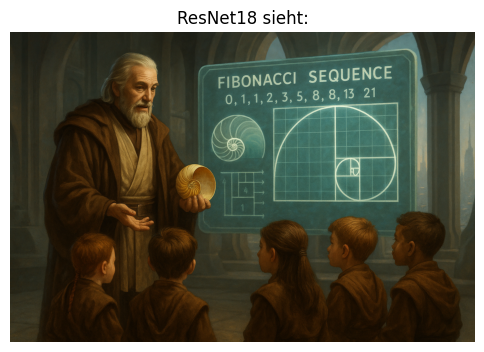

jellyfish: 34.03%
oscilloscope: 11.22%
bakery: 3.83%


In [21]:
# 3. Ein echtes Bild lokal hochladen
print("Bitte lade ein Bild hoch:")
uploaded = files.upload() # Dies öffnet einen Upload-Button im Output

# Den Dateinamen der hochgeladenen Datei holen
file_name = next(iter(uploaded))

# Das Bild öffnen
img_pil = Image.open(BytesIO(uploaded[file_name])).convert('RGB')
print(f"Bild '{file_name}' erfolgreich geladen!")

# 4. Preprocessing (Genau so, wie ResNet es erwartet!)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224), # ResNet braucht 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(img_pil)
input_batch = input_tensor.unsqueeze(0) # Mini-batch dimension hinzufügen (1, 3, 224, 224)

# 5. Vorhersage
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    resnet.to('cuda')

with torch.no_grad():
    output = resnet(input_batch)

# Top 3 Wahrscheinlichkeiten
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top3_prob, top3_catid = torch.topk(probabilities, 3)

# Anzeigen
plt.figure(figsize=(6,6))
plt.imshow(img_pil)
plt.axis('off')
plt.title("ResNet18 sieht:")
plt.show()

for i in range(top3_prob.size(0)):
    print(f"{imagenet_classes[top3_catid[i]]}: {top3_prob[i].item()*100:.2f}%")


Bitte lade ein Bild hoch:


Saving Dragon_ship.png to Dragon_ship.png
Bild 'Dragon_ship.png' erfolgreich geladen!


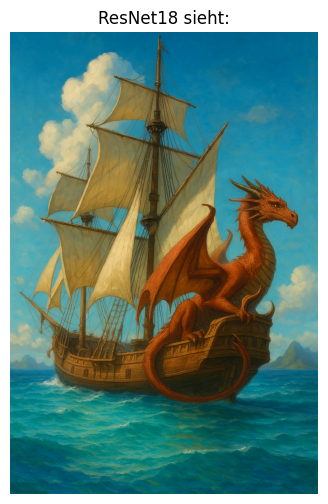

pirate: 62.21%
schooner: 17.80%
vase: 4.35%


In [22]:
# 3. Ein echtes Bild lokal hochladen
print("Bitte lade ein Bild hoch:")
uploaded = files.upload() # Dies öffnet einen Upload-Button im Output

# Den Dateinamen der hochgeladenen Datei holen
file_name = next(iter(uploaded))

# Das Bild öffnen
img_pil = Image.open(BytesIO(uploaded[file_name])).convert('RGB')
print(f"Bild '{file_name}' erfolgreich geladen!")

# 4. Preprocessing (Genau so, wie ResNet es erwartet!)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224), # ResNet braucht 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(img_pil)
input_batch = input_tensor.unsqueeze(0) # Mini-batch dimension hinzufügen (1, 3, 224, 224)

# 5. Vorhersage
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    resnet.to('cuda')

with torch.no_grad():
    output = resnet(input_batch)

# Top 3 Wahrscheinlichkeiten
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top3_prob, top3_catid = torch.topk(probabilities, 3)

# Anzeigen
plt.figure(figsize=(6,6))
plt.imshow(img_pil)
plt.axis('off')
plt.title("ResNet18 sieht:")
plt.show()

for i in range(top3_prob.size(0)):
    print(f"{imagenet_classes[top3_catid[i]]}: {top3_prob[i].item()*100:.2f}%")
